# Rotation Transformation
We meta-learn how to rotate images so that we can accurately classify rotated images. We use MNIST.

Import relevant packages

In [2]:
from operator import mul
from itertools import cycle

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import tqdm

from higher.patch import make_functional
from higher.utils import get_func_params
from sklearn.metrics import accuracy_score

%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

Define transformations to create standard and rotated images

In [4]:
transform_basic = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

transform_rotate = transforms.Compose([
    transforms.RandomRotation([30, 30]),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

Load the data and split the indices so that we both standard and rotated images in various sets. We also keep a part of the training data as unrotated test images in case it is useful.

In [5]:
train_set = datasets.MNIST(
    'data', train=True, transform=transform_basic, target_transform=None, download=True)
train_set_rotated = datasets.MNIST(
    'data', train=True, transform=transform_rotate, target_transform=None, download=True)

train_basic_indices = range(40000)
train_test_basic_indices = range(40000, 50000)
val_rotate_indices = range(50000, 60000)

In [6]:
train_basic_set = torch.utils.data.Subset(train_set, train_basic_indices)
train_test_basic_set = torch.utils.data.Subset(train_set, train_test_basic_indices)
val_rotate_set = torch.utils.data.Subset(
    train_set_rotated, val_rotate_indices)

In [7]:
test_set = datasets.MNIST(
    'data', train=False, transform=transform_rotate, target_transform=None, download=True)

Define data loaders

In [8]:
batch_size = 128

train_basic_set_loader = torch.utils.data.DataLoader(
    train_basic_set, batch_size=batch_size, shuffle=True)
train_test_basic_set_loader = torch.utils.data.DataLoader(
    train_test_basic_set, batch_size=batch_size, shuffle=True)
val_rotate_set_loader = torch.utils.data.DataLoader(
    val_rotate_set, batch_size=batch_size, shuffle=True)
test_set_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=True)

Set-up the device to use

In [9]:
if torch.cuda.is_available():  # checks whether a cuda gpu is available
    device = torch.cuda.current_device()
    print("use GPU", device)
    print("GPU ID {}".format(torch.cuda.current_device()))
else:
    print("use CPU")
    device = torch.device('cpu')  # sets the device to be CPU

use GPU 0
GPU ID 0


Define a function to do rotation by angle theta (in radians). We define the function in a way that allows us to differentiate with respect to theta.

In [10]:
def rot_img(x, theta, device):
    rot = torch.cat([torch.cat([torch.cos(theta), -torch.sin(theta), torch.tensor([0.], device=device)]),
                        torch.cat([torch.sin(theta), torch.cos(theta), torch.tensor([0.], device=device)])])
    grid = F.affine_grid(rot.expand([x.size()[0], 6]).view(-1, 2, 3), x.size())
    x = F.grid_sample(x, grid)
    return x

Define the model that we use - simple LeNet that will allow us to do fast experiments

In [11]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.in_channels = 1
        self.input_size = 28
        self.conv1 = nn.Conv2d(self.in_channels, 6, 5,
                               padding=2 if self.input_size == 28 else 0)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

A function to test a model on the test set

In [13]:
def test_classification_net(data_loader, model, device):
    '''
    This function reports classification accuracy over a dataset.
    '''
    model.eval()
    labels_list = []
    predictions_list = []
    with torch.no_grad():
        for i, (data, label) in enumerate(data_loader):
            data = data.to(device)
            label = label.to(device)

            logits = model(data)
            softmax = F.softmax(logits, dim=1)
            _, predictions = torch.max(softmax, dim=1)

            labels_list.extend(label.cpu().numpy().tolist())
            predictions_list.extend(predictions.cpu().numpy().tolist())
    accuracy = accuracy_score(labels_list, predictions_list)
    return 100 * accuracy

A function to test the model on the test set while doing the rotations manually with a specified angle

In [14]:
def test_classification_net_rot(data_loader, model, device, angle=0.0):
    '''
    This function reports classification accuracy over a dataset.
    '''
    model.eval()
    labels_list = []
    predictions_list = []
    with torch.no_grad():
        for i, (data, label) in enumerate(data_loader):
            data = data.to(device)
            if angle != 0.0:
                data = rot_img(data, angle, device)
            label = label.to(device)

            logits = model(data)
            softmax = F.softmax(logits, dim=1)
            _, predictions = torch.max(softmax, dim=1)

            labels_list.extend(label.cpu().numpy().tolist())
            predictions_list.extend(predictions.cpu().numpy().tolist())
    accuracy = accuracy_score(labels_list, predictions_list)
    return 100 * accuracy

Define a model to do the rotations - it has a meta-learnable parameter theta that represents the rotation angle in radians

In [16]:
class RotTransformer(nn.Module):
    def __init__(self, device):
        super(RotTransformer, self).__init__()
        self.theta = nn.Parameter(torch.FloatTensor([0.]))
        self.device = device

    # Rotation transformer network forward function
    def rot(self, x):
        rot = torch.cat([torch.cat([torch.cos(self.theta), -torch.sin(self.theta), torch.tensor([0.], device=self.device)]),
                         torch.cat([torch.sin(self.theta), torch.cos(self.theta), torch.tensor([0.], device=self.device)])])
        grid = F.affine_grid(rot.expand([x.size()[0], 6]).view(-1, 2, 3), x.size())
        x = F.grid_sample(x, grid)
        return x

    def forward(self, x):
        return self.rot(x)

We first train a simple model on standard images to see how it performs when applied to rotated images

In [19]:
acc_rotate_list = []
acc_basic_list = []
num_repetitions = 5

for e in range(num_repetitions):
    print('Repetition ' + str(e + 1))
    model = LeNet().to(device=device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss().to(device=device)

    num_epochs_meta = 5

    with tqdm.tqdm(total=num_epochs_meta) as pbar_epochs:
        for epoch in range(0, num_epochs_meta):
            for i, batch in enumerate(train_basic_set_loader):
                (input_, target) = batch
                input_ = input_.to(device=device)
                target = target.to(device=device)

                logits = model(input_)
                loss = criterion(logits, target)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            pbar_epochs.update(1)

    # testing
    acc_rotate = test_classification_net(test_set_loader, model, device)
    acc_rotate_list.append(acc_rotate)

    angle = torch.tensor([-np.pi/6], device=device)
    acc_basic = test_classification_net_rot(test_set_loader, model, device, angle)
    acc_basic_list.append(acc_basic)

100%|██████████| 5/5 [00:31<00:00,  6.31s/it]


Print statistics:

In [33]:
print('Accuracy on rotated test images: {:.2f} $\pm$ {:.2f}'.format(np.mean(acc_rotate_list), np.std(acc_rotate_list)))
print('Accuracy on standard position test images: {:.2f} $\pm$ {:.2f}'.format(np.mean(acc_basic_list), np.std(acc_basic_list)))

Accuracy on rotated test images: 81.79 $\pm$ 0.64
Accuracy on standard position test images: 98.40 $\pm$ 0.07


We see there is a large drop in accuracy if we apply the model on rotated images rather the same images without rotations

Now we use EvoGrad and meta-learning to train the model with images that are rotated by the rotation transformer. Rotation transformer is learned jointly alongside the base model. We will use random seeds to improve reproducibility since EvoGrad random noise perturbations depend on sampling of random numbers (but the precise accuracies may differ).

In [23]:
acc_rotate_list_evo_2mc = []
acc_basic_list_evo_2mc = []
angles_reps_2mc = []

# define the settings
num_repetitions = 5
torch_seeds = [1, 23, 345, 4567, 56789]
sigma = 0.001
temperature = 0.05
n_model_candidates = 2
num_epochs_meta = 5

for e in range(num_repetitions):
    print('Repetition ' + str(e + 1))
    torch.manual_seed(torch_seeds[e])
    
    model = LeNet().to(device=device)
    model_patched = make_functional(model)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss().to(device=device)

    feature_transformer = RotTransformer(device=device).to(device=device)

    meta_opt = torch.optim.Adam(feature_transformer.parameters(), lr=1e-2)
    angles = []

    with tqdm.tqdm(total=num_epochs_meta) as pbar_epochs:
        for epoch in range(0, num_epochs_meta):
            loaders = zip(train_basic_set_loader, cycle(val_rotate_set_loader))
            for i, batch in enumerate(loaders):
                ((input_, target), (input_rot, target_rot)) = batch
                input_ = input_.to(device=device)
                target = target.to(device=device)
                input_rot = input_rot.to(device=device)
                target_rot = target_rot.to(device=device)

                # base model training with images rotated using the rotation transformer
                logits = model(feature_transformer(input_))
                loss = criterion(logits, target)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # update the model parameters used for patching
                model_parameter = [i.detach() for i in get_func_params(model)]
                input_transformed = feature_transformer(input_)

                # create multiple model copies
                theta_list = [[j + sigma * torch.sign(torch.randn_like(j)) for j in model_parameter] for i in range(n_model_candidates)]
                pred_list = [model_patched(input_transformed, params=theta) for theta in theta_list]
                loss_list = [criterion(pred, target) for pred in pred_list]
                baseline_loss = criterion(model_patched(input_transformed, params=model_parameter), target)
                # calculate weights for the different model copies
                weights = torch.softmax(-torch.stack(loss_list)/temperature, 0)
                # merge the model copies
                theta_updated = [sum(map(mul, theta, weights)) for theta in zip(*theta_list)]
                pred_rot = model_patched(input_rot, params=theta_updated)
                loss_rot = criterion(pred_rot, target_rot)
                # update the meta-knowledge
                meta_opt.zero_grad()
                loss_rot.backward()
                meta_opt.step()
                angles.append(180 / 3.14 * feature_transformer.theta.item())
            pbar_epochs.update(1)

        angles_reps_2mc.append(angles)

    acc = test_classification_net(test_set_loader, model, device)
    acc_rotate_list_evo_2mc.append(acc)

    angle = torch.tensor([-np.pi/6], device=device)
    acc_basic = test_classification_net_rot(test_set_loader, model, device, angle)
    acc_basic_list_evo_2mc.append(acc_basic)

100%|██████████| 5/5 [01:18<00:00, 15.64s/it]


Print statistics:

In [24]:
print('Accuracy on rotated test images: {:.2f} $\pm$ {:.2f}'.format(np.mean(acc_rotate_list_evo_2mc), np.std(acc_rotate_list_evo_2mc)))
print('Accuracy on standard position test images: {:.2f} $\pm$ {:.2f}'.format(np.mean(acc_basic_list_evo_2mc), np.std(acc_basic_list_evo_2mc)))

Accuracy on rotated test images: 98.11 $\pm$ 0.32
Accuracy on standard position test images: 77.23 $\pm$ 6.55


Show what the learned angles look like during training:

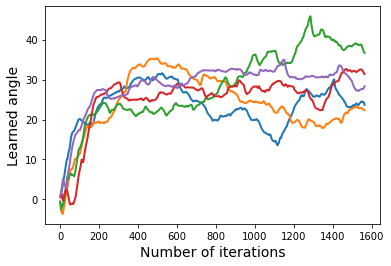

In [25]:
for angles_list in angles_reps_2mc:
    plt.plot(range(len(angles_list)), angles_list, linewidth=2.0)

plt.ylabel('Learned angle', fontsize=14)
plt.xlabel('Number of iterations', fontsize=14)
plt.savefig("RotTransformerLearnedAngles.pdf", bbox_inches='tight')
plt.show()

Print the average final meta-learned angle:

In [31]:
final_angles_2mc = [angles_list[-1] for angles_list in angles_reps_2mc]
print("{:.2f} $\pm$ {:.2f}".format(np.mean(final_angles_2mc), np.std(final_angles_2mc)))

28.47 $\pm$ 5.23


It's great to see the meta-learned angle is typically close to 30 degrees, which is the true value.